<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/001_gbif_pitta_nympha_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import ee

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [6]:
import geemap
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

from google.colab import files

#GBIF 데이터 수집

2024년 8월 11일을 기준으로, GBIF API를 이용하여 대한민국에서의 Pitta nympha(팔색조) 출현 데이터를 수집하였다. 데이터 수집은 좌표 정보가 포함된 경우와 인간에 의한 관측 데이터에 한정하여 수행하였다.

### 팔색조 (Pitta nympha)

팔색조는 대한민국에서 멸종위기 야생생물 Ⅱ급, 천연기념물 제204호, 국가적색목록 VU로 지정되어 있으며, IUCN 적색목록에서도 VU로 등재되어 있다. 이 종은 머리부터 꼬리까지 약 18cm로, 중형의 산림성 조류에 속한다. 4월경부터 대한민국의 제주도 및 남부 지방에 도래하여 번식기를 보내고, 9월경에는 월동지인 동남아시아로 이동하여 겨울을 난다. 즉, 팔색조는  대한민국에서 드문 여름철새이자 나그네새로, 여름동안 번식을 위해 도래하지만, 월동하지 않고 가을이 되면 월동지를 향해 이동하는 새이다. 최근 한반도의 기후가 온난화됨에 따라 산림 생태조사가 더욱 정밀하게 진행되면서, 경기도와 강원도 등 중부권에서도 번식이 확인되어 분포 지역이 확대되고 있다 (Lee, 2021).

Lee, W.-S. The ecology and culture of birds in Korea; Geobook: Seoul, Korea, 2021.

In [7]:
def get_gbif_species_data(species_name, country_code):
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,       # 학명
        "country": country_code,              # 국가 코드
        "hasCoordinate": "true",              # 좌표 여부
        "basisOfRecord": "HUMAN_OBSERVATION", # 인간 관측
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()

In [8]:
# 2024년 8월 11일 기준 대한민국 Fairy Pitta 검색
df = get_gbif_species_data("Pitta nympha", "KR")

# csv 파일 저장
df.to_csv("pitta_nympha_raw.csv", index=False)
files.download('pitta_nympha_raw.csv')

df = pd.read_csv("pitta_nympha_raw.csv")
df.head(1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4875314160,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-08-06T22:43:31.419+00:00,2024-08-08T03:40:21.272+00:00,478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "publishingOrgKey", "year", "month", "eventDate", "geometry"]]

# GeoDataFrame을 GeoPackage로 변환(pycrs 설치 필요)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_raw.gpkg", driver="GPKG")
files.download('pitta_nympha_raw.gpkg')

gdf = gpd.read_file("pitta_nympha_raw.gpkg")
gdf.head(1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,species,publishingOrgKey,year,month,eventDate,geometry
0,Pitta nympha,28eb1a3f-1c15-4a95-931a-4af90ecb574d,2024,6,2024-06-01T15:42:13,POINT (126.93219 35.41408)


In [11]:
# 연도 및 월별 데이터 분포 히트맵
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # 히트맵
    plt.figure(figsize=(h_size, h_size - 6))
    heatmap = plt.imshow(
        statistics.values, cmap="YlOrBr", origin="upper", aspect="auto"
    )

    # 각 픽셀 위치에 값 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(
                j, i, statistics.values[i, j], ha="center", va="center", color="black"
            )

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig("heatmap_plot.png")
    plt.show()

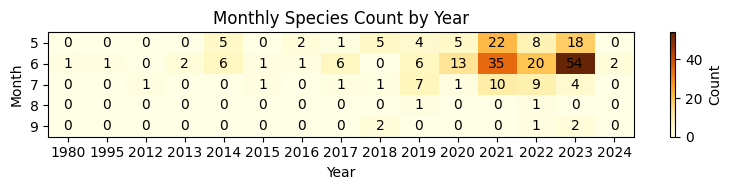

In [12]:
plot_heatmap(gdf)

## 데이터 전처리

### 속성 필터링
본 연구에서는 팔색조의 서식지를 예측하기 위해 최근 5년간(2019년~2023년) 대한민국 내에서 수집된 출현 데이터를 사용하였다. 분석은 팔색조의 활동이 활발한 시기인 5월부터 7월 사이의 데이터로 한정하여 수행하였다.

이 데이터를 사용하는 이유는 다음과 같다. 첫째, 최신 데이터는 현재의 환경 조건과 생태적 변화를 가장 잘 반영할 수 있다. 기후 변화와 인류 활동에 따른 환경 변화가 빠르게 진행되고 있는 상황에서, 최신 데이터를 사용하는 것은 서식지 예측 모델의 정확도를 높이는 데 필수적이다. 특히, 팔색조는 환경 변화에 민감하게 반응하는 종이므로 최신 데이터를 통해 보다 정확한 예측이 가능하다.

또한, 팔색조는 여름철에 활동이 활발한 철새로, 5월부터 7월 사이의 데이터는 이들의 이동 및 서식지 선택 패턴을 가장 잘 반영할 수 있다. 따라서 이 기간 동안의 데이터를 사용함으로써 팔색조의 실제 서식지와 이동 경로를 보다 정확하게 모델링할 수 있다.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

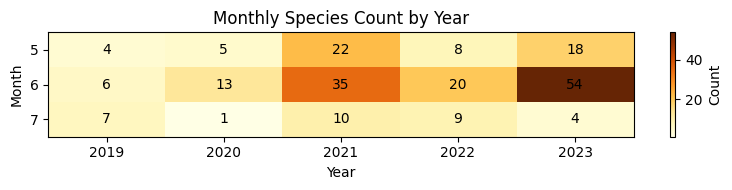

In [15]:
# 연도 및 월별 속성 필터링
gdf_filtered1 = gdf[
    (gdf['year'].between(2019, 2023)) &
    (gdf['month'].between(5, 7))
]

gdf_filtered1.to_file("pitta_nympha_filtered1.gpkg", driver="GPKG")
files.download('pitta_nympha_filtered1.gpkg')

plot_heatmap(gdf_filtered1)

In [16]:
# 개수 출력
gdf_count = len(gdf)
print(f'gdf의 개수: {gdf_count}')

gdf_filtered1_count = len(gdf_filtered1)
print(f'필터링된 gdf_filtered1의 개수: {gdf_filtered1_count}')

gdf의 개수: 260
필터링된 gdf_filtered1의 개수: 216


In [17]:
gdf_filtered1.head(1)

,species,publishingOrgKey,year,month,eventDate,geometry
2,Pitta nympha,28eb1a3f-1c15-4a95-931a-4af90ecb574d,2023,5,2023-05-27T13:33:36,POINT (126.72514 33.20314)


In [36]:
# GBIF API으로 기관명을 조회하는 함수
def get_org_name(publishingOrgKey):
    url = f"https://api.gbif.org/v1/organization/{publishingOrgKey}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("title", "Unknown")
    return "Unknown"

In [45]:
# 기관별 데이터 개수 그래프
def plot_org_counts(gdf, h_size=10):

    # 각 publishingOrgKey 별 데이터 개수 계산
    org_counts = gdf['publishingOrgKey'].value_counts()

    # 기관명을 한번만 조회하여 맵핑하는 딕셔너리 생성
    org_names = {key: get_org_name(key) for key in org_counts.index}

    # 데이터 개수를 높은 순으로 정렬
    org_counts = org_counts.sort_values(ascending=True)

    # 기관명을 기준으로 그래프 그리기
    plt.figure(figsize=(h_size, h_size - 6))
    org_counts.index = org_counts.index.map(org_names)  # 기관명을 맵핑하여 인덱스 교체
    org_counts.plot(kind='barh')  # 가로 막대 그래프로 변경
    plt.title('Number of Records per Organization')
    plt.ylabel('Organization Name')
    plt.xlabel('Number of Records')

    # 막대 위에 수치 표시
    for index, value in enumerate(org_counts):
        plt.text(value, index, str(value), va='center')

    plt.tight_layout()
    plt.show()

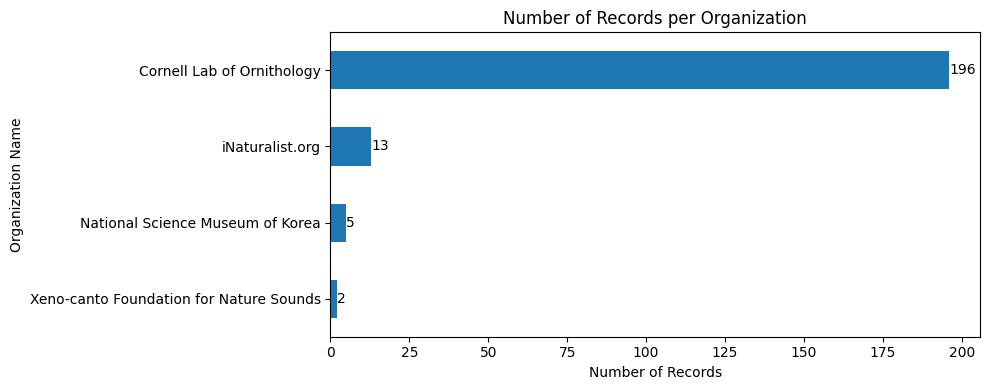

In [46]:
plot_org_counts(gdf_filtered1)

### 공간적 필터링

GBIF(Global Biodiversity Information Facility, 세계생물다양성정보기구)는 전 세계 다양한 기관들로부터 수집된 데이터를 단일 포털을 통해 접근할 수 있도록 제공하고 있다. 이러한 데이터 출처의 다양성은 각 기관의 조사 방법과 사용자가 상이함을 의미하며, 본 연구에서 사용된 팔색조 데이터 역시 Cornell Lab of Ornithology의 eBird 플랫폼, iNaturalist.org, 국립중앙박물관, xeno-canto 등 여러 출처에서 수집된 것이다. 이와 같은 맥락에서 동일한 생물종에 대한 데이터일지라도 수집된 환경, 방법론, 사용자 간의 차이로 인해 공간적 해석에 편차가 발생할 가능성이 존재한다. 따라서 이질적인 출처에서 수집된 데이터를 통합하여 분석할 때는 공간적 필터링 과정에서 특히 세심한 주의가 필요하다. 이는 데이터의 공간적 일관성을 확보하고, 분석 결과의 신뢰성을 제고하기 위한 필수적인 절차이다.